In [6]:
import subprocess
result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
print(result.stdout)

Wed Oct 15 20:16:07 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-12GB           On  | 00000000:03:00.0 Off |                    0 |
| N/A   33C    P0              24W / 250W |      0MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
import os
import signal


pid_to_kill = 1923433  

try:
    os.kill(pid_to_kill, signal.SIGTERM)
    print(f"✅ Killed process {pid_to_kill}")
    print("Wait 5 seconds, then restart your kernel and try again")
except:
    print(f"❌ Could not kill process {pid_to_kill}")
    print("Try: Go to Jupyter Hub → 'Running' tab → Stop that notebook")

✅ Killed process 1923433
Wait 5 seconds, then restart your kernel and try again


🔧 Running in CPU mode (GPU disabled to avoid memory issues)

CELEBRITY IMAGE CLASSIFIER - PREDICTION NOTEBOOK

STEP 1: Loading saved model and metadata...
----------------------------------------------------------------------
Loading model from: celebrity_detector_best.keras
 Model loaded successfully!
Loading metadata from: celebrity_detector_metadata.json
 Metadata loaded successfully!

 Model Information:
   Model Type: CNN_Model
   Test Accuracy: 96.46%
   Input Shape: (64, 64, 3)
   Number of Classes: 134
   Total Parameters: 1,504,806

STEP 2: Setting up prediction function...
----------------------------------------------------------------------
 Prediction function ready!

STEP 3: READY TO PREDICT!

 Analyzing image: ./006515.jpg
Making prediction...


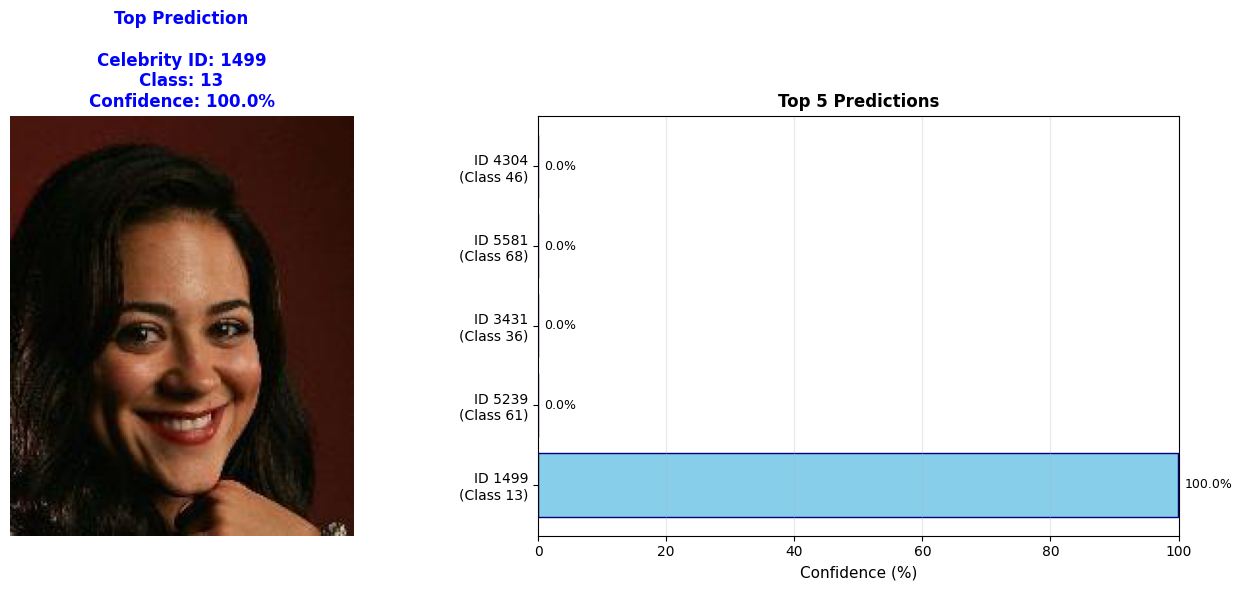


PREDICTION RESULTS
Image: 006515.jpg
Model: CNN_Model (Accuracy: 96.46%)

 Top 5 Predictions:
--------------------------------------------------------------------------------
Rank   Celebrity ID    Class      Confidence  
--------------------------------------------------------------------------------
  → 1    1499            13         99.98%
    2    5239            61         0.01%
    3    3431            36         0.00%
    4    5581            68         0.00%
    5    4304            46         0.00%

 Prediction complete!

 TO PREDICT ANOTHER IMAGE:
----------------------------------------------------------------------
1. Change the 'image_path' variable in STEP 3
2. Re-run the cell in STEP 3

 Note: Running on CPU mode (slower but no memory issues)
   To use GPU later, remove the os.environ line at the top


In [7]:

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU completely
print("🔧 Running in CPU mode (GPU disabled to avoid memory issues)")

import tensorflow as tf
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

print("\n" + "="*70)
print("CELEBRITY IMAGE CLASSIFIER - PREDICTION NOTEBOOK")
print("="*70)


print("\nSTEP 1: Loading saved model and metadata...")
print("-"*70)


MODEL_PATH = 'celebrity_detector_best.keras'
METADATA_PATH = 'celebrity_detector_metadata.json'


if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f" Model file not found: {MODEL_PATH}\nMake sure the file is in the same directory!")

if not os.path.exists(METADATA_PATH):
    raise FileNotFoundError(f" Metadata file not found: {METADATA_PATH}\nMake sure the file is in the same directory!")


print(f"Loading model from: {MODEL_PATH}")
best_model = tf.keras.models.load_model(MODEL_PATH)
print(f" Model loaded successfully!")


print(f"Loading metadata from: {METADATA_PATH}")
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)


MODEL_NAME = metadata['model_name']
TEST_ACCURACY = metadata['test_accuracy']
INPUT_SHAPE = tuple(metadata['input_shape'])
NUM_CLASSES = metadata['num_classes']
LABEL_TO_CELEBRITY = {int(k): int(v) for k, v in metadata['label_to_celebrity_id'].items()}

print(f" Metadata loaded successfully!")
print(f"\n Model Information:")
print(f"   Model Type: {MODEL_NAME}")
print(f"   Test Accuracy: {TEST_ACCURACY*100:.2f}%")
print(f"   Input Shape: {INPUT_SHAPE}")
print(f"   Number of Classes: {NUM_CLASSES}")
print(f"   Total Parameters: {best_model.count_params():,}")


print("\n" + "="*70)
print("STEP 2: Setting up prediction function...")
print("-"*70)

def predict_celebrity_image(image_path, model, top_k=5):
    """
    Predict celebrity from image
    
    Args:
        image_path: Path to the image file
        model: Loaded Keras model
        top_k: Number of top predictions to return
    
    Returns:
        Dictionary with prediction results
    """
    try:
        # Load and preprocess image
        img = Image.open(image_path).convert('RGB')
        
        # Resize to match training size (64x64)
        img_resized = img.resize((INPUT_SHAPE[0], INPUT_SHAPE[1]))
        
        # Convert to array and normalize (same as training)
        img_array = np.array(img_resized) / 255.0
        
        # Add batch dimension
        img_batch = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        predictions = model.predict(img_batch, verbose=0)
        
        # Get top K predictions
        top_indices = np.argsort(predictions[0])[::-1][:top_k]
        top_confidences = predictions[0][top_indices] * 100
        
        # Map class labels to celebrity IDs
        results = {
            'image_path': image_path,
            'top_predictions': []
        }
        
        for rank, (class_idx, confidence) in enumerate(zip(top_indices, top_confidences), 1):
            celebrity_id = LABEL_TO_CELEBRITY.get(int(class_idx), -1)
            
            results['top_predictions'].append({
                'rank': rank,
                'celebrity_class': int(class_idx),
                'celebrity_id': celebrity_id,
                'confidence': float(confidence)
            })
        
        return results
        
    except Exception as e:
        print(f" Error during prediction: {str(e)}")
        return None

print(" Prediction function ready!")


print("\n" + "="*70)
print("STEP 3: READY TO PREDICT!")
print("="*70)


image_path = "./006515.jpg"  
actual_celeb_id = None    


print(f"\n Analyzing image: {image_path}")

if not os.path.exists(image_path):
    print(f" ERROR: Image not found at {image_path}")
    print("\n Please:")
    print("   1. Update the 'image_path' variable above")
    print("   2. Make sure the file exists")
    print("   3. Check the file path is correct")
else:
   
    print("Making prediction...")
    results = predict_celebrity_image(image_path, best_model, top_k=5)
    
    if results:
      
        plt.figure(figsize=(14, 6))
        
        # Show original image
        img = Image.open(image_path)
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis('off')
        
        # Get top prediction
        top_pred = results['top_predictions'][0]
        
        # Create title
        title = f'Top Prediction\n\nCelebrity ID: {top_pred["celebrity_id"]}\n'
        title += f'Class: {top_pred["celebrity_class"]}\n'
        title += f'Confidence: {top_pred["confidence"]:.1f}%'
        
        # Add correctness indicator if actual ID provided
        if actual_celeb_id is not None:
            is_correct = (top_pred["celebrity_id"] == actual_celeb_id)
            color = 'green' if is_correct else 'red'
            status = ' CORRECT' if is_correct else ' INCORRECT'
            title += f'\n\n{status}'
        else:
            color = 'blue'
        
        plt.title(title, fontsize=12, fontweight='bold', color=color)
        
 
        plt.subplot(1, 2, 2)
        labels = [f'ID {p["celebrity_id"]}\n(Class {p["celebrity_class"]})' 
                  for p in results['top_predictions']]
        confidences = [p['confidence'] for p in results['top_predictions']]
        
     
        colors = ['green' if actual_celeb_id and p['celebrity_id'] == actual_celeb_id 
                  else 'skyblue' for p in results['top_predictions']]
        
        bars = plt.barh(range(len(labels)), confidences, color=colors, edgecolor='navy')
        plt.yticks(range(len(labels)), labels, fontsize=10)
        plt.xlabel('Confidence (%)', fontsize=11)
        plt.title('Top 5 Predictions', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
        plt.xlim(0, 100)
        
       
        for i, (bar, conf) in enumerate(zip(bars, confidences)):
            plt.text(conf + 1, i, f'{conf:.1f}%', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        

        print("\n" + "="*80)
        print("PREDICTION RESULTS")
        print("="*80)
        print(f"Image: {os.path.basename(image_path)}")
        print(f"Model: {MODEL_NAME} (Accuracy: {TEST_ACCURACY*100:.2f}%)")
        
        if actual_celeb_id is not None:
            print(f"\nActual Celebrity ID: {actual_celeb_id}")
            if top_pred["celebrity_id"] == actual_celeb_id:
                print("✅ Status: CORRECT PREDICTION!")
            else:
                print(f" Status: INCORRECT (Predicted: {top_pred['celebrity_id']})")
        
        print("\n Top 5 Predictions:")
        print("-"*80)
        print(f"{'Rank':<6} {'Celebrity ID':<15} {'Class':<10} {'Confidence':<12}")
        print("-"*80)
        
        for pred in results['top_predictions']:
            marker = "→ " if pred['rank'] == 1 else "  "
            check = "✓ " if actual_celeb_id and pred['celebrity_id'] == actual_celeb_id else "  "
            
            print(f"{check}{marker}{pred['rank']:<4} "
                  f"{pred['celebrity_id']:<15} "
                  f"{pred['celebrity_class']:<10} "
                  f"{pred['confidence']:.2f}%")
        
        print("="*80)
        
        print("\n Prediction complete!")
    else:
        print(" Prediction failed!")

print("\n" + "="*70)
print(" TO PREDICT ANOTHER IMAGE:")
print("-"*70)
print("1. Change the 'image_path' variable in STEP 3")
print("2. Re-run the cell in STEP 3")
print("="*70)

print("\n Note: Running on CPU mode (slower but no memory issues)")
print("   To use GPU later, remove the os.environ line at the top")